In [1]:
import pandas as pd
import numpy as np
import time
from pandas.tseries.offsets import DateOffset
from binance.client import Client
from datetime import datetime as dt
from sklearn.preprocessing import StandardScaler
import pickle
import matplotlib.pyplot as plt
import yfinance as yf

# GOLD

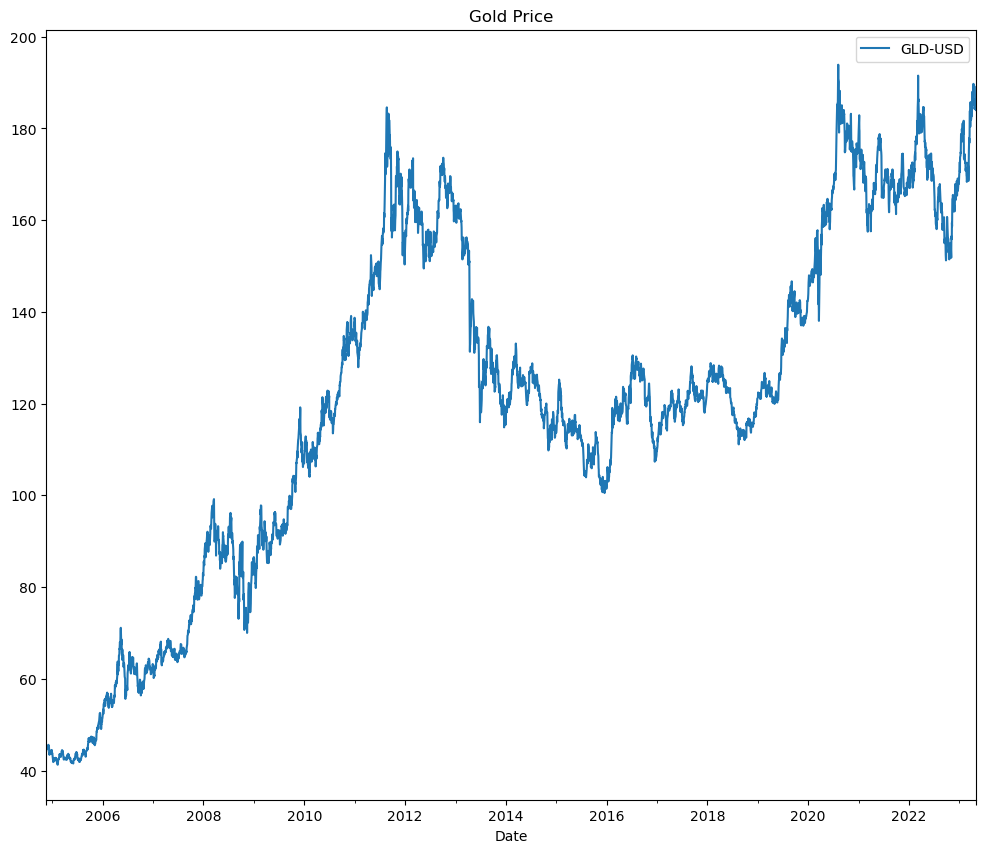

In [2]:
def get_gold_data():
    df_dates = pd.DataFrame(pd.date_range(
        '1988-12-01', pd.to_datetime('today').date()), columns=['Date'])
    df_dates.set_index('Date', inplace=True)
    # Hämta historiska guldprisdata (GLD är ticker-symbolen för SPDR Gold Shares ETF)
    gld_data = yf.download('GLD', end=dt.today().date(), progress=False)
    # gld_data.set_index('Date', inplace=True)

    # Behåll endast 'Close' priser och döp om kolumnen till 'GLD-USD'
    gld_data = gld_data[['Close']].rename(columns={'Close': 'GLD-USD'})

    df_dates = pd.DataFrame(pd.date_range(start=gld_data.index[0], end=pd.to_datetime( # type: ignore
        'today').date(), freq='D'), columns=['Date'])  # type: ignore

    df_dates.set_index('Date', inplace=True)
    gld_data = df_dates.merge(gld_data, how='left',
                              left_on='Date', right_index=True)
    # interpolating missing values
    gld_data.interpolate(method='linear', inplace=True)
    return gld_data

df_gold=get_gold_data()
df_gold.plot(figsize=(12, 10), title='Gold Price')
plt.show()


# Inflation

In [3]:
def initiate_data(inflation, df_dates, lang_dict, value_name):
    # display(inflation)
    inflation = inflation.melt(
        id_vars=['Year'], var_name='month', value_name=value_name)

    # use lang_dict to translate month names to numbers
    inflation['month'] = inflation['month'].map(lang_dict)

    inflation['Date'] = pd.to_datetime(inflation['Year'].astype(
        str) + '-' + inflation['month'].astype(str))
    inflation.set_index('Date', inplace=True)
    inflation.drop(['Year', 'month'], axis=1, inplace=True)
    inflation = df_dates.merge(
        inflation, how='left', left_on='Date', right_index=True)
    inflation.set_index('Date', inplace=True)
    inflation[value_name] = inflation[value_name].astype(str)
    inflation[value_name] = inflation[value_name].str.replace(',', '.')
    inflation[value_name] = inflation[value_name].str.replace(
        chr(8209), chr(45))
    inflation[value_name] = inflation[value_name].astype(float)
    inflation[value_name].interpolate(method='linear', inplace=True)
    return inflation


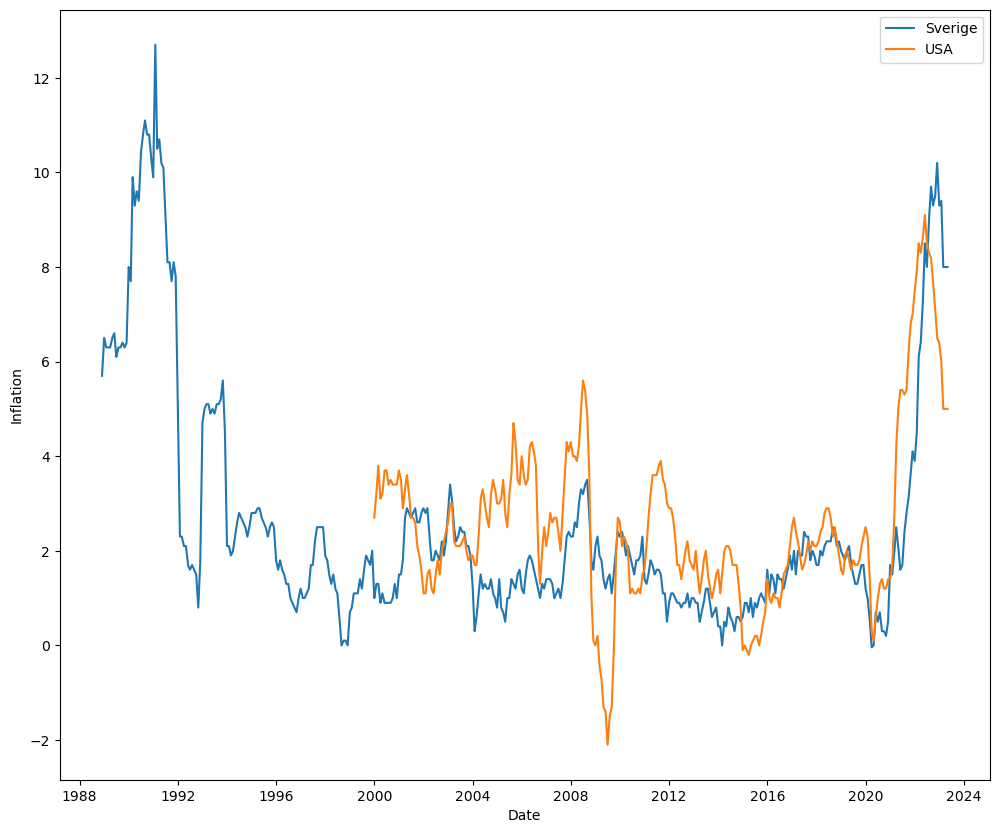

GLÖM INTE HORIZONS I PP(...)
GLÖM INTE HORIZONS I PP(...)
GLÖM INTE HORIZONS I PP(...)
GLÖM INTE HORIZONS I PP(...)
GLÖM INTE HORIZONS I PP(...)
GLÖM INTE HORIZONS I PP(...)


In [4]:

def get_inflation_data(graph=False):
    # Explain this function here
    # Create a dataframe with dates from 1988-12-01 to today
    df_dates = pd.DataFrame(pd.date_range(
        '1988-12-01', pd.to_datetime('today').date()), columns=['Date'])

    US_inflation = pd.read_html(
        'https://www.usinflationcalculator.com/inflation/current-inflation-rates/')
    US_inflation = US_inflation[0]
    # replace the cell including string starting with "Avail" with the NaN
    US_inflation.replace(to_replace=r'^Avail.*$',
                         value=np.nan, regex=True, inplace=True)
    # set the first row as the header and drop the first row
    US_inflation.columns = US_inflation.iloc[0]
    US_inflation.drop(US_inflation.index[0], inplace=True)
    US_inflation.drop('Ave', axis=1, inplace=True)

    # SE_inflation = pd.DataFrame()
    SE_inflation = pd.read_html(
        'https://www.scb.se/hitta-statistik/statistik-efter-amne/priser-och-konsumtion/konsumentprisindex/konsumentprisindex-kpi/pong/tabell-och-diagram/konsumentprisindex-med-fast-ranta-kpif-och-kpif-xe/kpif-12-manadersforandring/')
    SE_inflation = SE_inflation[0]
    SE_inflation.rename(columns={'År': 'Year'}, inplace=True)

    se_dict = dict(Jan='1', Feb='2', Mar='3', Apr='4', Maj='5', Jun='6',
                   Jul='7', Aug='8', Sep='9', Okt='10', Nov='11', Dec='12')
    us_dict = dict(Jan='1', Feb='2', Mar='3', Apr='4', May='5', Jun='6',
                   Jul='7', Aug='8', Sep='9', Oct='10', Nov='11', Dec='12')

    SE_inflation = initiate_data(
        SE_inflation, df_dates, se_dict, value_name='SE_inflation')
    # SE_inflation is in percent, divide by 10 to get decimal
    SE_inflation['SE_inflation'] = SE_inflation['SE_inflation'] / 10
    US_inflation = initiate_data(
        US_inflation, df_dates, us_dict,  value_name='US_inflation')

    if graph:
        # Do a simple plot
        fig, ax = plt.subplots(figsize=(12, 10))
        ax.plot(SE_inflation.index,
                SE_inflation['SE_inflation'], label='Sverige')
        ax.plot(US_inflation.index, US_inflation['US_inflation'], label='USA')
        ax.set_xlabel('Date')
        ax.set_ylabel('Inflation')
        ax.legend()
        plt.show()

    # concat and set one column to US_index and the other to SE_index
    inflations = pd.concat([US_inflation, SE_inflation], axis=1).copy()
    inflations = inflations.dropna()
    # inflations = add_horizon_columns(inflations, [75, 90, 250])
    print("GLÖM INTE HORIZONS I PP(...)")
    print("GLÖM INTE HORIZONS I PP(...)")
    print("GLÖM INTE HORIZONS I PP(...)")
    print("GLÖM INTE HORIZONS I PP(...)")
    print("GLÖM INTE HORIZONS I PP(...)")
    print("GLÖM INTE HORIZONS I PP(...)")
    return inflations


df_infl = get_inflation_data(graph=True)


In [5]:
MAX_MONTHS = 24


Timestamp('2023-05-02 00:00:00')

In [ ]:
# Get all the tickers from Binance
def get_data():
    # take the time
    start_time = time.time()
    
    api_key = '2jxiCQ8OIWmU4PZH4xfwKEY9KYerDkSWzwNCqoaMzj41eJgWBsSqA3VYqkt2wmdX'
    api_secret = 'YY1Qj1t0JZrE4tQdaBBxT8iwl2tbFalWp1FHjyZ9selBb6OnQ0Oj8aVdiXO7YLMz'

    client = Client(api_key, api_secret)

    # Hämta handelspar
    symbols = client.get_all_tickers()
    symbols = [
        symbol for symbol in symbols if symbol['symbol'].endswith('USDT')]

    # Sätt upp en tom lista för att lagra close-priser
    close_prices = {}

    # Ange den tidsram du vill ha för historiska data
    interval = Client.KLINE_INTERVAL_1DAY
    start = f"{MAX_MONTHS} month ago UTC"
    
    # Hämta close-priser för alla kryptovalutor
    dates = None

    # progress_bar = st.progress(0)  # Create a progress bar

    for idx, symbol in enumerate(symbols, 1):
        try:
            klines = client.get_historical_klines(
                symbol['symbol'], interval, start)
            if dates is None:
                # Extrahera och konvertera tidsstämplar till datum
                dates = [dt.fromtimestamp(
                    int(kline[0]) / 1000).strftime('%Y-%m-%d') for kline in klines]
            
            close_prices[symbol['symbol']] = [
                float(kline[4]) for kline in klines]
        except Exception as e:
            print(f"Kunde inte hämta data för {symbol['symbol']}: {e}")

        if idx % 10 == 0:
                print(f"This will take several minutes. Symbol number {idx} of {len(symbols)}: . . . . . . . . {symbol['symbol']}")

        # # Update the progress bar
        # if idx+1 == len(symbols):
        #     progress_text = f"Done! last symbol . . . . . . . . {symbol['symbol']} fetched."
        # else:
        #     progress_text = f"This will take several minutes. Symbol number {idx+1} of {len(symbols)}: . . . . . . . . {symbol['symbol']}"
        # progress_bar.progress((idx + 1) / len(symbols), progress_text)
    
    # Konvertera close_prices-dicten till en pandas DataFrame
    # print(close_prices)
    df = pd.DataFrame.from_dict(close_prices, orient='index').transpose()
    
    df = df.dropna(axis=1,how='all')  # remove columns with all nan
    
    # Lägg till datum som index för DataFrame
    
    df.index = pd.to_datetime(dates)   # type: ignore
    print(df.head())
    
    # print the time   
    tot_time = round((time.time() - start_time),1)
    # make it in minutes and seconds
    minutes = tot_time // 60
    seconds = tot_time % 60 
    print("Det tog {minutes} minuter och {seconds} sekunder att hämta alla kryptovalutor ---")
    return df

df = get_data()
df.to_csv('all_tickers.csv', index=True)


In [ ]:
# Specila preprocessing for crypto data
df = pd.read_csv('all_tickers.csv', index_col=0)

print(df.shape)
# drop the columns where all values are nan
df = df.dropna(axis=1,how='all')
print(df.shape)

s=int(0.9*len(df))

# remove all columns where there are more than s nan values
df = df.dropna(axis=1, thresh=s)

df.shape

In [ ]:
print(f'{df.isna().any().sum()} rader med någon nan \n{len(df)-df.isna().any().sum()} rader utan nan')
# df.isna().any().sum()

### applicera StandardScaler på alla kolumner (tickers) i df
Använd en .py som skapar nya kolumner och preprocessar data - samma .py överallt
StandardScaler får inte ha NaN's
Skapa en folder för alla StandardScalers som sparas

In [ ]:

from preprocess import preprocess as pp
# kör preprocess(...) och få tillbaka en ny df
df, predictors = pp(df, df_gold, df_infl)


In [ ]:
# Gör en funktion som applicerar StandardScaler() på en ticker och sparar den i en fil uppbyggd av namnet  på ticker.

def fit_and_save_scaler(df, column_name):
    # Kontrollera att kolumnnamnet finns i DataFrame
    if column_name not in df.columns:
        raise ValueError(f"Kolumnen '{column_name}' finns inte i DataFrame")

    # Skapa och träna en StandardScaler med den givna kolumnen
    scaler = StandardScaler()
    scaler.fit(df[[column_name]])

    # Spara StandardScaler i en fil
    file_name = f"scalers/{column_name}_scaler.pkl"
    with open(file_name, 'wb') as f:
        pickle.dump(scaler, f)

    print(f"StandardScaler för kolumn '{column_name}' sparad som '{file_name}'")
